# 05-LSTM classification

credit: https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/recurrent_network.py

An LSTM network for image classification problem. A many-to-one configuration according to http://karpathy.github.io/2015/05/21/rnn-effectiveness/.

Trained on CIFAR-10 dataset.

Original data size: (32,32,3)

Input data size: (32, 96) --> (data_dimension, sequence_length)

Training this example didn't get high accuracy, compared to training on MNIST dataset.

In [2]:
# Import modules
% matplotlib inline
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.contrib.rnn import BasicLSTMCell, static_rnn
import sys
sys.path.insert(0,'./utils/')
from CNNutils import BatchGenerator, preprocess_image, load_data

In [3]:
# Load cifar-10 dataset, use the first 1000 test samples for testing
train_set = load_data(mode='train')
test_set = load_data(mode='test')
Xtrain, Ytrain = preprocess_image(train_set)
Xtest, Ytest = preprocess_image(test_set)
Xtest = Xtest[0:1000, :, :]
Ytest = Ytest[0:1000]

(50000, 32, 96)


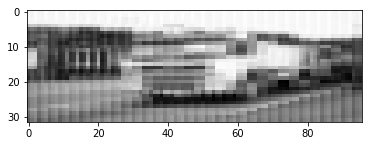

In [4]:
# Reshape data to target size. This essentially 'stretches' the data so each pixel's RGB value is lined up in the same row.
Xtrain_seq = Xtrain.reshape([-1,32,96])
Xtest_seq = Xtest.reshape([-1,32,96])
print(Xtrain_seq.shape)
plt.imshow(Xtrain_seq[1000], cmap='gray')

In [5]:
# Create batch generator. Set mini-batch size.
gen = BatchGenerator(Xtrain_seq, Ytrain, batch_size=128).initialize()
batch_size = 128
num_samples = Xtrain.shape[0]
sequence_length = 32
input_dim = 96
n_hidden = 512
num_class = 10

In [6]:
# Define TensorFlow variables
X_init = tf.placeholder(tf.float32, [None, sequence_length, input_dim])
y = tf.placeholder(tf.int32, [None, ])
out_w = tf.Variable(tf.random_normal([n_hidden, num_class], dtype=tf.float32))
out_b = tf.Variable(tf.random_normal([num_class]), dtype=tf.float32)
y_hot = tf.one_hot(y, 10, on_value=1, off_value=0)

In [7]:
# Split input tensor to a list, so that it fits into RNN.
X = tf.split(X_init, sequence_length, axis=1)
X = [tf.squeeze(i, axis=1) for i in X]

In [ ]:
# Construct LSTM network
lstm = BasicLSTMCell(n_hidden)
hidden_initial = tf.zeros([n_hidden,])
lstm_output, _ = static_rnn(lstm, X, dtype=tf.float32)

# Set loss, accuracy, etc.
predictions = tf.matmul(lstm_output[-1], out_w) + out_b
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y_hot))
optimizer = tf.train.AdadeltaOptimizer().minimize(loss)
test_pred = tf.equal(tf.argmax(predictions, 1), tf.argmax(y_hot, 1))
accuracy = tf.reduce_mean(tf.cast(test_pred, tf.float32))

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in range(40):
    for _ in range(50000//128):
        xbatch, ybatch = next(gen)
        sess.run([optimizer], feed_dict={X_init: xbatch, y: ybatch})
    l, acc = sess.run([loss, accuracy], feed_dict = {X_init: Xtrain_seq, y: Ytrain})
    print('Epoch {}, loss {}, accuracy {}%'.format(epoch, l, acc*100))
        
print('Optimization compmlete.')

Epoch 0, loss 2.500906467437744, accuracy 13.140000402927399%
Epoch 1, loss 2.4143500328063965, accuracy 14.774000644683838%
Epoch 2, loss 2.3446078300476074, accuracy 16.600000858306885%
Epoch 3, loss 2.289031505584717, accuracy 18.31600069999695%
Epoch 4, loss 2.2445530891418457, accuracy 19.68400329351425%
Epoch 5, loss 2.2085087299346924, accuracy 20.764002203941345%
Epoch 6, loss 2.1788134574890137, accuracy 21.568000316619873%
Epoch 7, loss 2.1538963317871094, accuracy 22.283999621868134%
Epoch 8, loss 2.1325981616973877, accuracy 23.05000126361847%
Epoch 9, loss 2.11407732963562, accuracy 23.75600039958954%
Epoch 10, loss 2.0977227687835693, accuracy 24.371999502182007%
Epoch 11, loss 2.083091974258423, accuracy 24.893999099731445%
Epoch 12, loss 2.0698602199554443, accuracy 25.415998697280884%
Epoch 13, loss 2.057785987854004, accuracy 25.82399845123291%
Epoch 14, loss 2.046687364578247, accuracy 26.257997751235962%
Epoch 15, loss 2.0364232063293457, accuracy 26.669999957084656

In [14]:
# Test on test batch
acc = sess.run([accuracy], feed_dict = {X_init: Xtest_seq, y: Ytest})
acc

[0.31999999]